# Практическое задание 1. Предобработка и векторизация

В данной тетрадке предтавлен пайплайн для классификации спам текстов.
Ваша задача:
1. Аналогично приведенному ниже коду разработать модель с предобработкой  и TF-IDF векторизацией
2. Сравнить качество с BoW
3. Как можно ускорить обучение в данном случае?

In [ ]:
import numpy as np
import wget
import zipfile

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Маленький набор для теста - BoW + Logistic Regression

In [2]:
data = {
    'text': [
        'Buy now and get 50% off!',    # спам
        'Meeting at 10 am tomorrow',   # не спам
        'Congratulations, you won!',   # спам
        'Please find the attached file',  # не спам
        'Limited time offer - claim your prize!',  # спам
        'Reminder: Team meeting at 3 pm',   # не спам
    ],
    'label': [1, 0, 1, 0, 1, 0]  # 1 - спам, 0 - не спам
}


spam_data = pd.DataFrame(data)

# Разделение данных на обучающую и тестовую выборки
train_data, test_data, train_labels, test_labels = train_test_split(
    spam_data['text'], spam_data['label'], test_size=0.2, random_state=42
)

In [3]:
def create_bow(data):
    vocabulary = set(word for sentence in data for word in sentence.split())
    bow_matrix = np.zeros((len(data), len(vocabulary)), dtype=int)

    for i, sentence in enumerate(data):
        for j, word in enumerate(vocabulary):
            bow_matrix[i, j] = sentence.split().count(word)

    return bow_matrix, list(vocabulary)

train_bow, vocabulary = create_bow(train_data)
test_bow = np.zeros((len(test_data), len(vocabulary)), dtype=int)

for i, sentence in enumerate(test_data):
    for j, word in enumerate(vocabulary):
        test_bow[i, j] = sentence.split().count(word)

In [4]:
model_bow = LogisticRegression()
model_bow.fit(train_bow, train_labels)
predictions_bow = model_bow.predict(test_bow)

# Вывод результатов для Bag of Words
print("Results for Bag of Words:")
print("Accuracy:", accuracy_score(test_labels, predictions_bow))
print("Classification Report:\n", classification_report(test_labels, predictions_bow))

Results for Bag of Words:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



# Визуализируем матрицу векторов BoW

In [5]:
train_bow

array([[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]])

# Большой набор данных 

In [6]:
# Загрузка датасета
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
wget.download(url, "smsspamcollection.zip")

# Распаковка архива
with zipfile.ZipFile("smsspamcollection.zip", "r") as zip_ref:
    zip_ref.extractall("")

# Чтение датасета
sms_data = pd.read_table("SMSSpamCollection", header=None, names=['label', 'text'])

# Преобразование меток в числовой формат (spam=1, ham=0)
sms_data['label'] = sms_data['label'].map({'ham': 0, 'spam': 1})

In [7]:
# внимание, на выполнение этой ячейки может уйти несоклько минут!
train_data, test_data, train_labels, test_labels = train_test_split(
    sms_data['text'], sms_data['label'], test_size=0.2, random_state=42
)

train_bow, vocabulary = create_bow(train_data)
test_bow = np.zeros((len(test_data), len(vocabulary)), dtype=int)

for i, sentence in enumerate(test_data):
    for j, word in enumerate(vocabulary):
        test_bow[i, j] = sentence.split().count(word)

In [8]:
model_bow = LogisticRegression()
model_bow.fit(train_bow, train_labels)
predictions_bow = model_bow.predict(test_bow)

# Вывод результатов для Bag of Words
print("Results for Bag of Words:")
print("Accuracy:", accuracy_score(test_labels, predictions_bow))
print("Classification Report:\n", classification_report(test_labels, predictions_bow))

Results for Bag of Words:
Accuracy: 0.979372197309417
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



# Pеализация tf idf

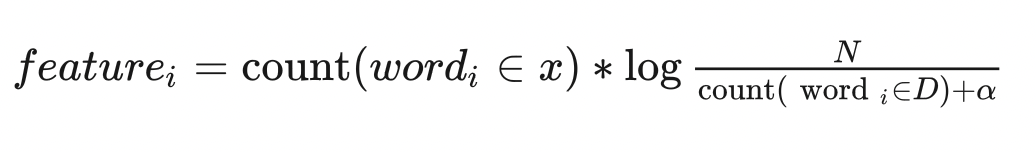

In [11]:
class CustomTFIDFVectorizer:
    """
    Расчет TF-IDF для текста
        alpha -- коэффициент сглаживания, по умолчанию = 1, если задачть = 0 сглаживания не будет
    """
    def __init__(self, alpha=1):
        self._alpha = alpha
        self._dict_idf = {}
    
    def transform(self, data, y=None):
        # Подсчет TF
        tf_dict = {}
        for word in self._dict_idf:
            tf_word = np.zeros(len(data), dtype=float)
            for i, doc in enumerate(data):
                text = doc if isinstance(doc, list) else doc.split()
                count_word = text.count(word)
                tf_word[i] = count_word / len(text) if len(text) != 0 else 0
            tf_dict[word] = tf_word
        
        # Умножение на IDF
        tfidf_matrix = np.zeros((len(data), len(self._dict_idf)), dtype=float)
        for i, doc in enumerate(data):
            for j, word in enumerate(self._dict_idf):
                tfidf_matrix[i][j] = tf_dict[word][i] * self._dict_idf[word]
        
        return tfidf_matrix

    def fit_transform(self, data, y=None):
        return self.fit(data).transform(data)

    def fit(self, data, y=None):
        # Построение словаря и подсчет IDF
        N = len(data)
        words = set([word for text in data for word in (text if isinstance(text, list) else text.split())])
        for word in words:
            count_word = sum(1 for text in data if word in (text if isinstance(text, list) else text.split()))
            self._dict_idf[word] = np.log(N / (count_word + self._alpha)) + self._alpha

        return self
    
    def get_feature_names_out(self):
        return [d for d in self._dict_idf.keys()]

### Tests

In [17]:
texts = [
         'this is the first document',
         'this document is the second document',
         'and this is the third one',
         'is this the first document',
     ]

words = ['second', 'first', 'document', 'is', 'the', 'one', 'and', 'this', 'third']

def tf_idf(n, ws, c):
    return c*(np.log(4/(n + 1))+1)/ws

answer_features = [[ tf_idf(sum(1 for t in texts if w in t.split()), len(text.split()), text.split().count(w)) for w in words] for text in texts]

answers_df = pd.DataFrame(answer_features, columns=words)

answers_df

,second,first,document,is,the,one,and,this,third
0,0.000000,0.257536,0.200000,0.155371,0.155371,0.000000,0.000000,0.155371,0.000000
1,0.282191,0.000000,0.333333,0.129476,0.129476,0.000000,0.000000,0.129476,0.000000
2,0.000000,0.000000,0.000000,0.129476,0.129476,0.282191,0.282191,0.129476,0.282191
3,0.000000,0.257536,0.200000,0.155371,0.155371,0.000000,0.000000,0.155371,0.000000


In [248]:
custom_vectorizer = CustomTFIDFVectorizer()
result_features = custom_vectorizer.fit_transform(texts)

result_features

array([[0.        , 0.25753641, 0.2       , 0.15537129, 0.15537129,
        0.        , 0.        , 0.15537129, 0.        ],
       [0.2821912 , 0.        , 0.33333333, 0.12947607, 0.12947607,
        0.        , 0.        , 0.12947607, 0.        ],
       [0.        , 0.        , 0.        , 0.12947607, 0.12947607,
        0.2821912 , 0.2821912 , 0.12947607, 0.2821912 ],
       [0.        , 0.25753641, 0.2       , 0.15537129, 0.15537129,
        0.        , 0.        , 0.15537129, 0.        ]])

In [220]:
custom_vectorizer.get_feature_names_out()

['second', 'first', 'document', 'is', 'the', 'one', 'and', 'this', 'third']

In [221]:
tfidf_df_result = pd.DataFrame(result_features, columns=custom_vectorizer.get_feature_names_out())
tfidf_df_result

,second,first,document,is,the,one,and,this,third
0,0.000000,0.257536,0.200000,0.155371,0.155371,0.000000,0.000000,0.155371,0.000000
1,0.282191,0.000000,0.333333,0.129476,0.129476,0.000000,0.000000,0.129476,0.000000
2,0.000000,0.000000,0.000000,0.129476,0.129476,0.282191,0.282191,0.129476,0.282191
3,0.000000,0.257536,0.200000,0.155371,0.155371,0.000000,0.000000,0.155371,0.000000


In [ ]:
custom_vectorizer = CustomTFIDFVectorizer()
result_features = custom_vectorizer.fit_transform(texts)

features = custom_vectorizer.get_feature_names_out()

tfidf_df_result = pd.DataFrame(result_features, columns=features)

for i in range(len(features)):
    word = features[i]
    for j in range(len(tfidf_df_result[word])):
        if answers_df[word][j] - tfidf_df_result[word][j] < 0.000001:
            print('tf-idf для слова {} в {} предложении расчитан правильно'.format(word, j + 1))
        else:
            print('tf-idf для слова {} в {} предложении неправильно расчитан, получили {}, а должен быть {}'.format(word, j + 1, tfidf_df_result[word][j], answers_df[word][j]))


tf-idf для слова second в 1 предложении расчитан правильно
tf-idf для слова second в 2 предложении расчитан правильно
tf-idf для слова second в 3 предложении расчитан правильно
tf-idf для слова second в 4 предложении расчитан правильно
tf-idf для слова is в 1 предложении расчитан правильно
tf-idf для слова is в 2 предложении расчитан правильно
tf-idf для слова is в 3 предложении расчитан правильно
tf-idf для слова is в 4 предложении расчитан правильно
tf-idf для слова one в 1 предложении расчитан правильно
tf-idf для слова one в 2 предложении расчитан правильно
tf-idf для слова one в 3 предложении расчитан правильно
tf-idf для слова one в 4 предложении расчитан правильно
tf-idf для слова the в 1 предложении расчитан правильно
tf-idf для слова the в 2 предложении расчитан правильно
tf-idf для слова the в 3 предложении расчитан правильно
tf-idf для слова the в 4 предложении расчитан правильно
tf-idf для слова this в 1 предложении расчитан правильно
tf-idf для слова this в 2 предложении р

## Предобработка NLTK

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

class TextPreprocessor:
    """
    Предобработка с помощью NLTK
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punctuation = set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit_transform(self, data, y=None):
        return self.fit(data).transform(data)

    def fit(self, data, y=None):
        return self

    def transform(self, data, y=None):
        return [self._transform(text) for text in data]

    def _transform(self, data):
        # Привести к нижнему регистру и токенизировать
        tokens = nltk.word_tokenize(data.lower())

        # Исключить пунктуацию, стоп-слова
        return [self.lemmatizer.lemmatize(t) for t in tokens
                if t not in self.stop_words and t not in self.punctuation ]

In [243]:
texts_test = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

texts_test_df = pd.DataFrame(texts_test)[0]
texts_test_df

0              This is the first document.
1    This document is the second document.
2               And this is the third one.
3              Is this the first document?
Name: 0, dtype: object

In [246]:
texts_test_transforms = TextPreprocessor().transform(texts_test_df)
texts_test_transforms

[['first', 'document'],
 ['document', 'second', 'document'],
 ['third', 'one'],
 ['first', 'document']]

## Пайплайн с кастомной векторизацией tf-idf

In [18]:
from sklearn.pipeline import Pipeline

#  Тестирование пайплайна предобработки данных
pipeline_preprocessor = Pipeline([
    ('preprocessor', TextPreprocessor()), 
])

print(pipeline_preprocessor.fit_transform(texts))

pipeline_vectorizer = Pipeline([
    ('preprocessor', TextPreprocessor()), 
    ('vectorizer', CustomTFIDFVectorizer()), 
])

print(pipeline_vectorizer.fit_transform(texts))

[['first', 'document'], ['document', 'second', 'document'], ['third', 'one'], ['first', 'document']]
[[0.         0.         0.5        0.         0.64384104]
 [0.56438239 0.         0.66666667 0.         0.        ]
 [0.         0.84657359 0.         0.84657359 0.        ]
 [0.         0.         0.5        0.         0.64384104]]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.95      0.85      0.89       149

    accuracy                           0.97      1115
   macro avg       0.96      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 0.9730941704035875

Confusion Matrix:


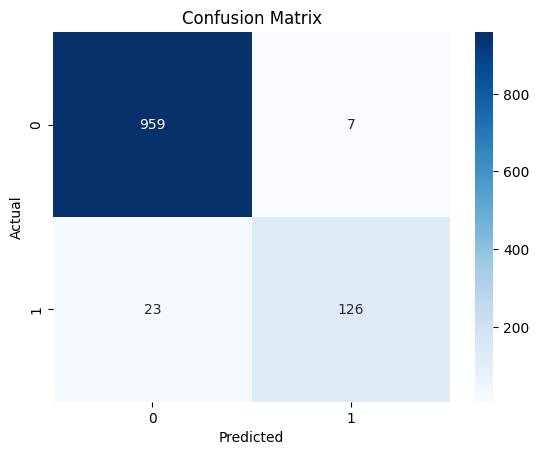

In [14]:
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Разделение датасета на обучающий и тестовый
X_train, X_test, y_train, y_test = train_test_split(
    sms_data['text'], sms_data['label'], test_size=0.2, random_state=42
)

# Создание пайплайна предобработки данных и обучения
pipeline_lr = Pipeline([
    ('preprocessor', TextPreprocessor()), 
    ('vectorizer', CustomTFIDFVectorizer()), 
    ('classifier', LogisticRegression()) 
])

# Запуск пайплайна
pipeline_lr.fit(X_train, y_train)
y_pred_test_lr = pipeline_lr.predict(X_test)

# Вывод метрик
print(classification_report(y_test, y_pred_test_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_test_lr))

# Графическое представление матрицы ошибок
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_test_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()